In [65]:
import os
import subprocess

import geopandas as gpd
import pandas as pd
import sys
wos = 'win' in sys.platform
if wos:
    from osgeo import gdal
    from multiprocess import Pool
    from funcs import get_bounds
else:
#     import gdal
    from osgeo import gdal
    from multiprocessing import Pool
import numpy as np
from numba import jit
from tqdm.auto import tqdm
import math
from shapely import geometry
from pathlib import Path


In [3]:
tile_size_px = [1000,1000] #x,y
tile_oxerlap_px = 150
output_downsample = 0.5
output_folder = r'/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/tiles'
geotiff_folder = r'/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323' if not wos else r'{}'.format(os.getcwd())+r'\\test_imagery\\VIVID_Landgate_20190910_112102323'
input_file_ext = '.tif'
output_compression = 'JPEG'

In [4]:
# you must have v0.8 or up to use use_pygeos
import pkg_resources
pkg_resources.get_distribution('geopandas').version

'0.9.0'

In [5]:
# !conda install -c conda-forge pygeos
gpd.options.use_pygeos = True
print(gpd.options.use_pygeos)

True


In [6]:
%%time
# search folder and all sub folders for 'input_file_ext' files
geo_tiff_list = []
for root, dirs, files in os.walk(geotiff_folder):
    for file in files:
        if file.endswith(input_file_ext):
            geo_tiff_list.append(os.path.join(root, file))
            
len(geo_tiff_list) 

CPU times: user 418 µs, sys: 252 µs, total: 670 µs
Wall time: 304 µs


17

In [7]:
if not wos:
    def get_bounds(tif_path):
    #     open file
        data = gdal.Open(tif_path)
    #     grab bounds
        geoTransform = data.GetGeoTransform()
        left = geoTransform[0]
        top = geoTransform[3]
        right = left + geoTransform[1] * data.RasterXSize
        bottom = top + geoTransform[5] * data.RasterYSize
        geo_tiff_bounds_dict = {'top':top,'left':left,'bottom':bottom,'right':right,'tif_path':tif_path}
        return geo_tiff_bounds_dict

In [8]:
geo_tiff_bounds =get_bounds(geo_tiff_list[0])
geo_tiff_bounds

{'top': -34.27734375,
 'left': 116.455078125,
 'bottom': -34.365234375,
 'right': 116.54296875,
 'tif_path': '/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323103.tif'}

In [9]:
pool = Pool(3)
with pool:
    list(tqdm(pool.imap(get_bounds,geo_tiff_list[:3]), total=3))

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
%%time
for i in geo_tiff_list:
    get_bounds(i)

CPU times: user 2.26 ms, sys: 1.36 ms, total: 3.62 ms
Wall time: 14 ms


In [11]:
%%time
# use multiprocessing to extract raster bounds
# interesting when using a small number of geotiffs its is slightly quicker to just run this as a loop
# however once you get over a 100 or so this method is much quicker
with Pool() as pool:
    geo_tiff_bounds = list(tqdm(pool.imap(get_bounds, geo_tiff_list), total=len(geo_tiff_list)))

# make new array with only bounds 
pure_bounds = []
for geo_tif_bounds in geo_tiff_bounds:
    pure_bounds.append([geo_tif_bounds['top'],geo_tif_bounds['left'],geo_tif_bounds['bottom'],geo_tif_bounds['right']])
# convert into numpy array
pure_bounds_np = np.array(pure_bounds)
# # grab max extents
bound_y_max = float(pure_bounds_np[:,0].max()) #top
bound_x_min = float(pure_bounds_np[:,1].min()) #left
bound_y_min = float(pure_bounds_np[:,2].min()) #bottom
bound_x_max = float(pure_bounds_np[:,3].max()) #right

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 27.8 ms, sys: 33.2 ms, total: 61.1 ms
Wall time: 96 ms


In [12]:
# open one image to get the pixel size
test_raster = gdal.Open(geo_tiff_list[0])
test_raster_gt =test_raster.GetGeoTransform()
pixel_size_x = test_raster_gt[1]
pixel_size_y = test_raster_gt[5]
print(pixel_size_x,pixel_size_y)

4.487879136029412e-06 -4.487879136029412e-06


In [13]:
# calculate the geographical distance in each direction each tile must be from the last tile
x_move = pixel_size_x*(tile_size_px[0]-tile_oxerlap_px)
y_move = pixel_size_y*(tile_size_px[1]-tile_oxerlap_px)

# calculate the geographical size of each tile
x_tile_size = pixel_size_x*tile_size_px[0]
y_tile_size = pixel_size_y*tile_size_px[1]
print(x_move,y_move)

0.003814697265625 -0.003814697265625


In [14]:
# calculate the number of cols so we can avoid using while loops
number_of_cols = math.ceil(abs((bound_x_max-bound_x_min)/x_move))
number_of_cols

139

In [15]:
# calculate the number of rows so we can avoid using while loops
number_of_rows = math.ceil(abs((bound_y_max-bound_y_min)/y_move))
number_of_rows

93

In [16]:
geo_tiff_bounds[0]['top']

-34.27734375

In [17]:
# will return a list of geotiffs which intersect 
def intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds):
#     loop over each geotiff
    intersecting_geotiffs = set()
    
    for geo_bounds in geo_tiff_bounds:
#         check is tile top or bottom is inside geotiff
        if (geo_bounds['top'] > tile_dict['top'] > geo_bounds['bottom'] or 
            geo_bounds['top'] > tile_dict['bottom'] > geo_bounds['bottom']):
#         check if left or right are inside a geotiff
            if geo_bounds['right'] > tile_dict['left'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
            if geo_bounds['right'] > tile_dict['right'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
    return intersecting_geotiffs

In [18]:
# will take tile bounds and only export them if they fall within a geotiff
# this is called row by row by pool below
def make_polygons(row):
    tile_polygon_list = []
    tile_top = bound_y_max + y_move*row
    tile_bottom = tile_top + y_tile_size
    tile_left = bound_x_min

    for col in range(0,number_of_cols):
        tile_left = bound_x_min + col*x_move
        tile_right = tile_left + x_tile_size
        tile_dict = {'top':tile_top,'left':tile_left,'bottom':tile_bottom,'right':tile_right}
        tile_list = np.array([tile_top,tile_left,tile_bottom,tile_right])
#         check if valid tile
        intersect = intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds)
        if len(intersect) > 0:
            polygon = {'geometry':geometry.Polygon([[tile_left, tile_top], [tile_right, tile_top], [tile_right, tile_bottom], [tile_left, tile_bottom]]),
                      'intersect':intersect, 'row':row, 'col':col}
            tile_polygon_list.append(polygon)
    return tile_polygon_list


In [19]:
%%time
tile_polygon_list = []
for row in range(0,number_of_rows):
    tile_polygon_list.append(make_polygons(row))

CPU times: user 138 ms, sys: 0 ns, total: 138 ms
Wall time: 137 ms


In [20]:
%%time
# multiprocess making polygons
with Pool() as pool:
    tile_polygon_list = pool.map(make_polygons, range(0,number_of_rows))

# this is returned as a list of list so it must be flattened
tile_polygon_list = list(np.concatenate(tile_polygon_list).ravel())

CPU times: user 252 ms, sys: 50.1 ms, total: 302 ms
Wall time: 378 ms


In [21]:
tile_polygon_list[0]

{'geometry': <shapely.geometry.polygon.Polygon at 0x7fa284cf6e20>,
 'intersect': {'/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323022.tif'},
 'row': 0,
 'col': 0}

In [22]:
%%time
#  convert into geodataframe
polygon_tiles_gpd = gpd.GeoDataFrame(tile_polygon_list,geometry='geometry',crs='EPSG:4326')
del polygon_tiles_gpd['intersect']

CPU times: user 30.7 ms, sys: 9 µs, total: 30.8 ms
Wall time: 45.3 ms


<AxesSubplot:>

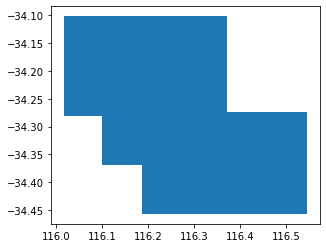

In [22]:
polygon_tiles_gpd.plot()

In [23]:
if not wos:
    polygon_tiles_gpd.to_file("/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/output.gpkg", driver="GPKG")
else:
    polygon_tiles_gpd.to_file(r'{}'.format(os.getcwd())+r'\\test_imagery\\VIVID_Landgate_20190910_112102323\\output.gpkg', driver="GPKG")    



In [24]:
tile_polygon_list[46]

{'geometry': <shapely.geometry.polygon.Polygon at 0x7fa284d64fa0>,
 'intersect': {'/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323023.tif',
  '/media/nick/2TB Working 2/Projects/GeoTIFF_tiler_data/VIVID_Landgate_20190910_112102323/VIVID_Landgate_20190910_112102323032.tif'},
 'row': 0,
 'col': 46}

In [25]:
%%time
geo_tiff_with_tiles = []
# make a list of which tiles are within which geotiffs
# loop over each geotiff
for geo_tiff in tqdm(geo_tiff_list):
    tiles_inside_geo_tiff = []
#     loop over each tile and check if the geotiff is the the intersect list
    for tile in tile_polygon_list:
        if geo_tiff in tile['intersect']:
#             we count this so we know if the tile will be incomplete or not
            incomplete = len(tile['intersect'])>1
#             build dict with geom the current row and col for naming
            tiles_inside_geo_tiff.append({'geometry':tile['geometry'],'row':tile['row'],'col':tile['col'],'incomplete':incomplete})
    geo_tiff_with_tiles.append([geo_tiff,tiles_inside_geo_tiff])   

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 37.3 ms


In [26]:
# geo_tiff_with_tiles[0]

In [45]:
# loop over each geotiff
# for geotiff in tqdm(geo_tiff_with_tiles):
def cut_tiles(geotiff):
#     grab path to to file and open it
    geotiff_open = gdal.Open(geotiff[0])
#     grab the filename and strip the extention
    geo_tiff_filename = os.path.basename(geotiff[0]).replace(input_file_ext,'')
    incomplete_tile_list = []
    for tile in geotiff[1]:
        time_geometry = tile['geometry']
#         shapely bounds returns "minx, miny, maxx, maxy" but we need minx, maxy, maxx, miny
        top = list(time_geometry.bounds)[3]
        bottom = list(time_geometry.bounds)[1]
        left = list(time_geometry.bounds)[0]
        right =list(time_geometry.bounds)[2]
        
#         make row folder path
        output_row_folder = os.path.join(output_folder,str(tile['row']))
#       make row folder if nessasary
        Path(output_row_folder).mkdir(parents=True, exist_ok=True)
        export_file_name = str(tile['row'])+'_'+str(tile['col'])+'.tif'
        
#         check if tile is incomplete if so append the getiff name so that it is unique
        if tile['incomplete']:
            append_name = '-'+geo_tiff_filename+'_incomplete.tif'
            export_file_name = export_file_name.replace('.tif',append_name)
#             add tile to list so we dont need to refind them to compile incomplete tiles
            export_file_path = os.path.join(output_row_folder,export_file_name)
            incomplete_tile_list.append(export_file_path)
        else:
            export_file_path = os.path.join(output_row_folder,export_file_name)
            
#             print('yes')

        

#     clip the data
#         make a string of tile dims to pass as a command line arg, this is ugly, would like a better option
        tile_clip_string = str(left) +' '+str(top) +' '+str(right) +' '+str(bottom)
    
        translate_options = gdal.TranslateOptions(gdal.ParseCommandLine("-projwin "+tile_clip_string)
                                                 ,creationOptions=['COMPRESS='+output_compression])
        
        tile_clip = gdal.Translate(export_file_path, geotiff_open, options = translate_options)
#     close the tile
        tile_clip = None
#         break
    return incomplete_tile_list

    

In [46]:
# single threaded 
# for tile in tqdm(geo_tiff_with_tiles):
#     cut_tiles(tile)

In [133]:
pool = Pool()
with pool:
    incomplete_tile_list = list(tqdm(pool.imap(cut_tiles,geo_tiff_with_tiles), total=len(geo_tiff_with_tiles)))

  0%|          | 0/17 [00:00<?, ?it/s]

In [134]:
#  the pool above returns all the incomplete tiles as a list of list, we need a flat list
flat_incomplete_tile_list = [item for sublist in incomplete_tile_list for item in sublist]
print(len(flat_incomplete_tile_list),'incomplete tiles')

2148 incomplete tiles


In [135]:
incomplete_tile_file_names = []
# from the flat list make a new list with just rows and cols to filter by
for incomplete_tile in flat_incomplete_tile_list:
    incomplete_tile_file_names.append(os.path.basename(incomplete_tile).split('-')[0])

In [136]:
# make a new datframe with paths and row/cols
incomplete_tile_df = pd.DataFrame(
    {'incomplete_tiles': flat_incomplete_tile_list,
     'row_col': incomplete_tile_file_names
    })

In [137]:
# handy little gdal tool to merge files
def merge_tiles(merge_imgs, output_path):
    merge_command = ['gdal_merge.py', '-o', output_path, '-co','COMPRESS='+output_compression]
    for name in merge_imgs:
        merge_command.append(name)
    subprocess.run(merge_command)

In [148]:
def join_incomplete_tile(unique_tiles):
# for unique_tiles in incomplete_tile_df.row_col.unique():
#     filter the datframe down to only onw row and col
    gapminder_2002 = incomplete_tile_df[incomplete_tile_df['row_col']==unique_tiles]
#     get paths as list
    combine_these = gapminder_2002['incomplete_tiles'].tolist()
#     get export name by removing the geotiff names from end
    export_file_name = os.path.basename(combine_these[0]).split('-')[0]+'.tif'
#     grab the folder from the first tile
    export_dir_path = os.path.dirname(combine_these[0])
#     biuld full export path
    export_full_path = os.path.join(export_dir_path,export_file_name)
#     use gdal gdal_merge.py to merge the tiles
    merge_tiles(combine_these,export_full_path)
#     remove the incomplete tiles and msk files
    for incomplete_tile in combine_these:
        try:
            os.remove(incomplete_tile)
        except:
            print('could not remove')
        try:
            os.remove(incomplete_tile+'.msk')
        except:
            print('could not remove')
#     break
    

In [ ]:
unique_tiles_list = incomplete_tile_df.row_col.unique()
pool = Pool()
with pool:
    incomplete_tile_list = list(tqdm(pool.imap(join_incomplete_tile,unique_tiles_list), total=len(unique_tiles_list)))

  0%|          | 0/1038 [00:00<?, ?it/s]

could not remove
could not remove
